## descarga de datos

In [ ]:
! curl -L -o fer2013.zip https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.3M  100 60.3M    0     0  43.0M      0  0:00:01  0:00:01 --:--:--  140M


In [ ]:
! unzip fer2013.zip -d fer

In [ ]:
! curl -L -o fer2013plus.zip https://www.kaggle.com/api/v1/datasets/download/subhaditya/fer2013plus

In [ ]:
! unzip fer2013plus.zip -d fer_plus

## revisión de dataset

In [ ]:
import os

def list_folders_with_file_count(start_dir):
  """
  Lists folders in a directory tree and the number of files within each folder.

  Args:
    start_dir: The starting directory to traverse.
  """
  for root, dirs, files in os.walk(start_dir):
    # Only print for directories
    if os.path.isdir(root):
      indent = '  ' * (root.count(os.sep) - start_dir.count(os.sep))
      print(f"{indent}{os.path.basename(root)}: {len(files)} files")

# Example usage with the unzipped directories
list_folders_with_file_count('.')


.: 1 files
  .config: 8 files
    logs: 0 files
      2025.05.14: 6 files
    configurations: 1 files
  fer: 0 files
    test: 0 files
      surprise: 831 files
      happy: 1774 files
      fear: 1024 files
      disgust: 111 files
      angry: 958 files
      sad: 1247 files
      neutral: 1233 files
    train: 0 files
      surprise: 3171 files
      happy: 7215 files
      fear: 4097 files
      disgust: 436 files
      angry: 3995 files
      sad: 4830 files
      neutral: 4965 files
  sample_data: 6 files


In [ ]:
train_path = "fer/train"
test_path = "fer/test"
labels = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

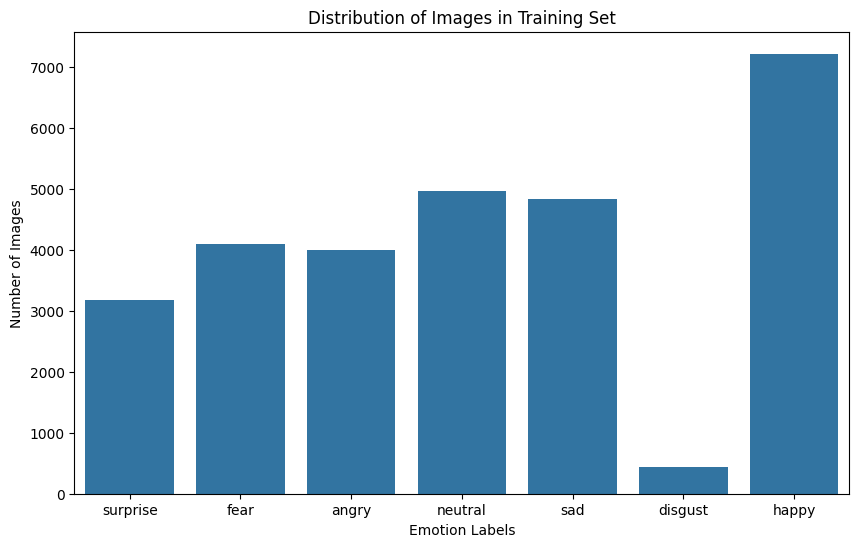

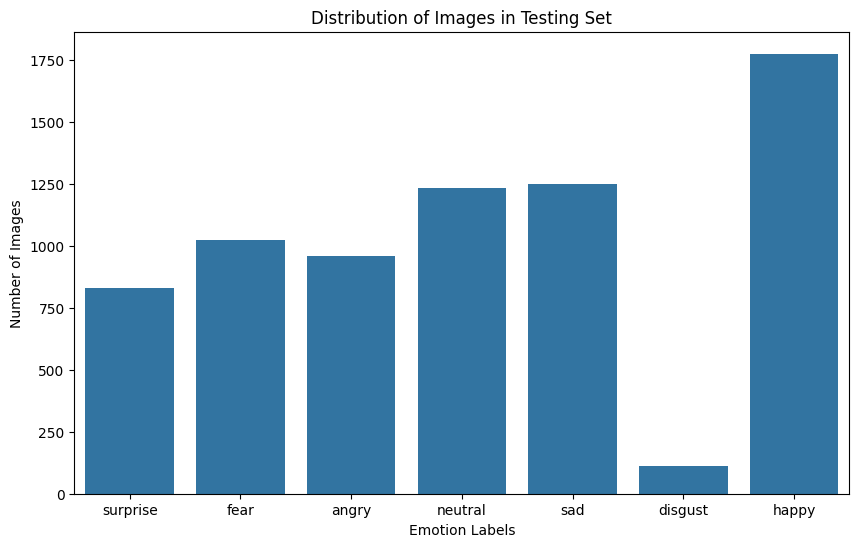

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Function to count images per label in a directory
def count_images_per_label(directory, labels):
  counts = {}
  for label in labels:
    label_dir = os.path.join(directory, label)
    if os.path.isdir(label_dir):
      counts[label] = len(os.listdir(label_dir))
    else:
      counts[label] = 0
  return counts

# Get counts for train and test sets
train_counts = count_images_per_label(train_path, labels)
test_counts = count_images_per_label(test_path, labels)

# Create bar plot for training data distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Distribution of Images in Training Set')
plt.xlabel('Emotion Labels')
plt.ylabel('Number of Images')
plt.show()

# Create bar plot for testing data distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title('Distribution of Images in Testing Set')
plt.xlabel('Emotion Labels')
plt.ylabel('Number of Images')
plt.show()

# dataset y dataloader pytorch

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Configuración inicial
RANDOM_SEED = 42
BATCH_SIZE = 64

DATA_MEAN = None  # Se calculará automáticamente
DATA_STD = None   # Se calculará automáticamente

# Transformaciones base para cálculo de media/std
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Cargar dataset temporal para cálculo de media/std
temp_dataset = ImageFolder(root='fer/train', transform=base_transform)

# Función para calcular media y std
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

DATA_MEAN, DATA_STD = calculate_mean_std(temp_dataset)

# Transformaciones personalizadas
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=5),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])

# Cargar datasets
train_dataset = ImageFolder(root='fer/train', transform=train_transform)
test_dataset = ImageFolder(root='fer/test', transform=test_transform)

# Función para balanceo de clases
def create_balanced_sampler(dataset):
    class_counts = np.bincount(dataset.targets)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[dataset.targets]
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights)*2,  # Oversampling 2x
        replacement=True
    )

# Crear samplers y dataloaders
train_sampler = create_balanced_sampler(train_dataset)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Función para verificar balanceo
def check_class_distribution(loader):
    class_counts = np.zeros(len(loader.dataset.classes))
    for _, labels in loader:
        counts = np.bincount(labels.numpy(), minlength=len(class_counts))
        class_counts += counts
    return class_counts / class_counts.sum()

# Verificaciones
print(f"Clases: {train_dataset.classes}")
print(f"Media del dataset: {DATA_MEAN.item():.4f}")
print(f"Desviación estándar: {DATA_STD.item():.4f}")
print(f"\nDistribución original (train): {np.bincount(train_dataset.targets)}")
print(f"Distribución balanceada por batch (ejemplo):")
print(check_class_distribution(train_loader))

# Verificación de dimensiones
sample_batch = next(iter(train_loader))
print(f"\nForma del batch: {sample_batch[0].shape}")
print(f"Rango de valores: [{sample_batch[0].min():.4f}, {sample_batch[0].max():.4f}]")

# Longitud de los datasets
print(f"\nTotal batches de entrenamiento: {len(train_loader)}")
print(f"Total batches de validación: {len(test_loader)}")
print(f"Muestras por época: {len(train_sampler)}")

Clases: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Media del dataset: 0.5077
Desviación estándar: 0.2120

Distribución original (train): [3995  436 4097 7215 4965 4830 3171]
Distribución balanceada por batch (ejemplo):
[0.14181964 0.14408374 0.14382249 0.1397297  0.14213313 0.14303877
 0.14537253]

Forma del batch: torch.Size([64, 1, 48, 48])
Rango de valores: [-2.3947, 2.3217]

Total batches de entrenamiento: 898
Total batches de validación: 113
Muestras por época: 57418


Class to index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


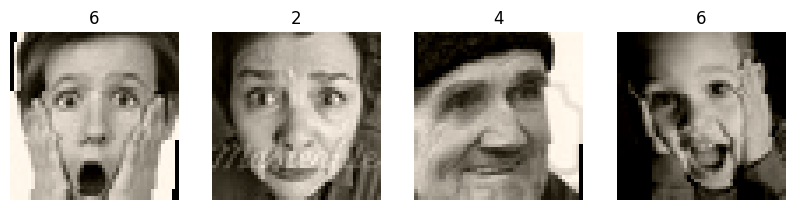

In [ ]:
import numpy as np
# If you have a DataLoader, you can iterate through it
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Class to index mapping:", train_dataset.class_to_idx)


# Function to display images
def imshow(img):
    # Unnormalize the image
    # Mean and std from normalization: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img.numpy().transpose((1, 2, 0)) + mean
    img = np.clip(img, 0, 1) # Clip values to be within [0, 1] after unnormalization
    plt.imshow(img)
    plt.axis('off')

# Display a few images
fig = plt.figure(figsize=(10, 4))
for i in range(4): # Display 4 images
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    imshow(images[i])
    # Assuming labels is a list of class names (e.g., ['surprise', 'fear', ...])
    # If labels are integers, you need to map them to class names
    ax.set_title(labels[i].item() if isinstance(labels, torch.Tensor) else labels[i])

plt.show()

## Red CBAM-4CNN

In [1]:
import torch
from torch import nn

class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.gmp = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        gap = self.gap(x).view(b, c)
        gmp = self.gmp(x).view(b, c)

        gap = self.fc(gap)
        gmp = self.fc(gmp)

        weights = self.sigmoid(gap + gmp).view(b, c, 1, 1)
        return x * weights

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        combined = torch.cat([avg_out, max_out], dim=1)
        weights = self.sigmoid(self.conv(combined))
        return x * weights

class CBAMBlock(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.ca = ChannelAttention(channel)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

class CBAM4CNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        def conv_block(in_c, out_c, num_layers, pool=True):
            layers = []
            for i in range(num_layers):
                layers += [
                    nn.Conv2d(in_c if i==0 else out_c, out_c, 3, padding=1),
                    nn.BatchNorm2d(out_c),
                    nn.ReLU(inplace=True)
                ]
            if pool:
                layers += [
                    CBAMBlock(out_c),
                    nn.MaxPool2d(2),
                    nn.Dropout2d(0.3)
                ]
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            # Bloque 1
            conv_block(1, 64, 2),
            # Bloque 2
            conv_block(64, 128, 3),
            # Bloque 3
            conv_block(128, 256, 4),
            # Bloque 4 (sin dropout final)
            nn.Sequential(
                conv_block(256, 512, 4)[:-2],  # Elimina dropout y pooling
                nn.MaxPool2d(2)
            )
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512*3*3, num_classes),
            nn.Softmax(dim=1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [ ]:
## visualización de la arquitectura

In [2]:
! pip install netron
! pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 76.0 MB/s eta 0:00:00


In [4]:
model = CBAM4CNN(num_classes=7)

# Define the output file name
onnx_file_name = "cbam4cnn_model.onnx"

dummy_input = torch.randn(64, 1, 48, 48)

# Export the model
torch.onnx.export(model,               # model being run
                  dummy_input,         # model input (or a tuple for multiple inputs)
                  onnx_file_name,      # where to save the model (can be a file or file-like object)
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=11,    # the ONNX version to export the model to
                  do_constant_folding=True, # whether to execute constant folding for optimization
                  input_names = ['input'], # the name of the input node(s)
                  output_names = ['output'], # the name of the output node(s)
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

print(f"Model exported to {onnx_file_name}")


Model exported to cbam4cnn_model.onnx


## Entrenamiento

### lr scheduler ReduceLROnPlateau

In [ ]:
! pip install torchmetrics

Using cuda device

Epoch 1/50


Train Loss: 3.6770 | Val Loss: 1.6635
Val Accuracy: 0.3540 | Val F1: 0.2781

Epoch 2/50


Train Loss: 3.0862 | Val Loss: 1.4651
Val Accuracy: 0.4361 | Val F1: 0.3834

Epoch 3/50


Train Loss: 2.7012 | Val Loss: 1.3366
Val Accuracy: 0.4805 | Val F1: 0.4096

Epoch 4/50


Train Loss: 2.4791 | Val Loss: 1.2873
Val Accuracy: 0.5135 | Val F1: 0.4395

Epoch 5/50


Train Loss: 2.3039 | Val Loss: 1.1984
Val Accuracy: 0.5343 | Val F1: 0.4760

Epoch 6/50


Train Loss: 2.1783 | Val Loss: 1.1672
Val Accuracy: 0.5548 | Val F1: 0.5097

Epoch 7/50


Train Loss: 2.0544 | Val Loss: 1.2169
Val Accuracy: 0.5489 | Val F1: 0.4979

Epoch 8/50


Train Loss: 1.9688 | Val Loss: 1.1380
Val Accuracy: 0.5769 | Val F1: 0.5251

Epoch 9/50


Train Loss: 1.9174 | Val Loss: 1.1290
Val Accuracy: 0.5854 | Val F1: 0.5445

Epoch 10/50


Train Loss: 1.8434 | Val Loss: 1.0710
Val Accuracy: 0.5986 | Val F1: 0.5635

Epoch 11/50


Train Loss: 1.7853 | Val Loss: 1.1245
Val Accuracy: 0.5931 | Val F1: 0.5691

Epoch 12/50


Train Loss: 1.7529 | Val Loss: 1.0569
Val Accuracy: 0.6076 | Val F1: 0.5756

Epoch 13/50


Train Loss: 1.7055 | Val Loss: 1.0302
Val Accuracy: 0.6181 | Val F1: 0.5993

Epoch 14/50


Train Loss: 1.6610 | Val Loss: 1.0343
Val Accuracy: 0.6181 | Val F1: 0.6008

Epoch 15/50


Train Loss: 1.6368 | Val Loss: 1.0763
Val Accuracy: 0.6077 | Val F1: 0.5798

Epoch 16/50


Train Loss: 1.5978 | Val Loss: 1.0436
Val Accuracy: 0.6219 | Val F1: 0.5966

Epoch 17/50


Train Loss: 1.5636 | Val Loss: 1.0275
Val Accuracy: 0.6301 | Val F1: 0.6097

Epoch 18/50


Train Loss: 1.5488 | Val Loss: 1.0606
Val Accuracy: 0.6158 | Val F1: 0.5846

Epoch 19/50


Train Loss: 1.5255 | Val Loss: 1.0397
Val Accuracy: 0.6244 | Val F1: 0.5948

Epoch 20/50


Train Loss: 1.4905 | Val Loss: 1.0600
Val Accuracy: 0.6241 | Val F1: 0.5971

Epoch 21/50


Train Loss: 1.4679 | Val Loss: 1.0281
Val Accuracy: 0.6258 | Val F1: 0.6069

Epoch 22/50


Train Loss: 1.3142 | Val Loss: 1.0062
Val Accuracy: 0.6524 | Val F1: 0.6366

Epoch 23/50


Train Loss: 1.2345 | Val Loss: 1.0434
Val Accuracy: 0.6415 | Val F1: 0.6334

Epoch 24/50


Train Loss: 1.1824 | Val Loss: 1.0542
Val Accuracy: 0.6491 | Val F1: 0.6374

Epoch 25/50


Train Loss: 1.1547 | Val Loss: 1.0379
Val Accuracy: 0.6485 | Val F1: 0.6390

Epoch 26/50


Train Loss: 1.1322 | Val Loss: 1.0199
Val Accuracy: 0.6532 | Val F1: 0.6405

Epoch 27/50


Train Loss: 1.0873 | Val Loss: 1.1121
Val Accuracy: 0.6453 | Val F1: 0.6323

Epoch 28/50


Train Loss: 1.0510 | Val Loss: 1.0666
Val Accuracy: 0.6552 | Val F1: 0.6383

Epoch 29/50


Train Loss: 1.0261 | Val Loss: 1.0867
Val Accuracy: 0.6546 | Val F1: 0.6361

Epoch 30/50


Train Loss: 0.9966 | Val Loss: 1.0893
Val Accuracy: 0.6551 | Val F1: 0.6386

Epoch 31/50


Train Loss: 0.9545 | Val Loss: 1.1076
Val Accuracy: 0.6510 | Val F1: 0.6305

Epoch 32/50


Train Loss: 0.9457 | Val Loss: 1.1331
Val Accuracy: 0.6549 | Val F1: 0.6346

Epoch 33/50


Train Loss: 0.8176 | Val Loss: 1.1640
Val Accuracy: 0.6643 | Val F1: 0.6420

Epoch 34/50


Train Loss: 0.7590 | Val Loss: 1.2065
Val Accuracy: 0.6613 | Val F1: 0.6423

Epoch 35/50


Train Loss: 0.7276 | Val Loss: 1.2218
Val Accuracy: 0.6608 | Val F1: 0.6453

Epoch 36/50


Train Loss: 0.6924 | Val Loss: 1.2449
Val Accuracy: 0.6592 | Val F1: 0.6410

Epoch 37/50


Train Loss: 0.6647 | Val Loss: 1.2793
Val Accuracy: 0.6532 | Val F1: 0.6384

Epoch 38/50


Train Loss: 0.5899 | Val Loss: 1.2987
Val Accuracy: 0.6592 | Val F1: 0.6451

Epoch 39/50


Train Loss: 0.5675 | Val Loss: 1.3393
Val Accuracy: 0.6630 | Val F1: 0.6464

Epoch 40/50


Train Loss: 0.5318 | Val Loss: 1.3855
Val Accuracy: 0.6591 | Val F1: 0.6469

Epoch 41/50


Train Loss: 0.5107 | Val Loss: 1.3724
Val Accuracy: 0.6619 | Val F1: 0.6473

Epoch 42/50


Train Loss: 0.4704 | Val Loss: 1.4211
Val Accuracy: 0.6605 | Val F1: 0.6446

Epoch 43/50


Train Loss: 0.4608 | Val Loss: 1.4539
Val Accuracy: 0.6649 | Val F1: 0.6472

Epoch 44/50


Train Loss: 0.4398 | Val Loss: 1.4402
Val Accuracy: 0.6599 | Val F1: 0.6462

Epoch 45/50


Train Loss: 0.4255 | Val Loss: 1.4592
Val Accuracy: 0.6599 | Val F1: 0.6447

Epoch 46/50


Train Loss: 0.4197 | Val Loss: 1.4862
Val Accuracy: 0.6598 | Val F1: 0.6471

Epoch 47/50


Train Loss: 0.4045 | Val Loss: 1.5025
Val Accuracy: 0.6552 | Val F1: 0.6380

Epoch 48/50


Train Loss: 0.3957 | Val Loss: 1.5129
Val Accuracy: 0.6591 | Val F1: 0.6452

Epoch 49/50


Train Loss: 0.3817 | Val Loss: 1.5478
Val Accuracy: 0.6598 | Val F1: 0.6489

Epoch 50/50


Train Loss: 0.3823 | Val Loss: 1.5155
Val Accuracy: 0.6587 | Val F1: 0.6454

Best Validation Accuracy: 0.6649


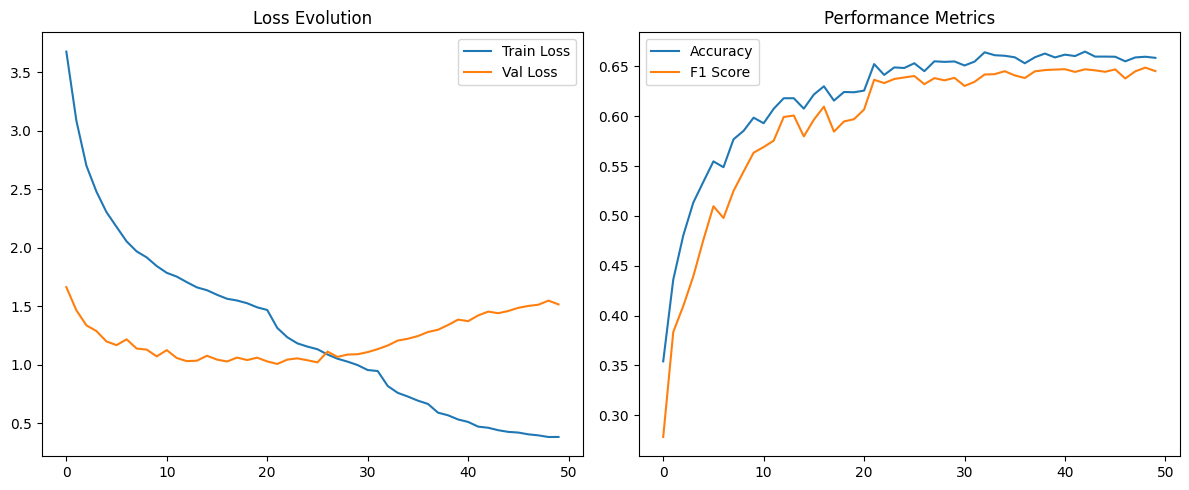

100%|██████████| 113/113 [00:03<00:00, 34.80it/s]


Final Test Accuracy: 0.6649
Final Test F1 Score: 0.6472


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
import copy
import torchmetrics

# Configuración de entrenamiento
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {DEVICE} device')
EPOCHS = 50
LR = 1e-3
CHECKPOINT_PATH = 'best_model.pth'

# Métricas
train_losses = []
val_losses = []
accuracies = []
f1_scores = []

# Inicialización del modelo
model = CBAM4CNN(num_classes=7).to(DEVICE)

# Quitar la capa Softmax final (corrección importante)
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5, verbose=True)

# Métricas de TorchMetrics
train_acc_metric = torchmetrics.Accuracy(task='multiclass', num_classes=7).to(DEVICE)
val_acc_metric = torchmetrics.Accuracy(task='multiclass', num_classes=7).to(DEVICE)
f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=7, average='macro').to(DEVICE)

# Checkpoint inicial
best_acc = 0.0
best_weights = copy.deepcopy(model.state_dict())

def train_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc='Training', leave=False)

    for inputs, labels in progress_bar:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_acc_metric.update(outputs.softmax(dim=1), labels)

        progress_bar.set_postfix({'Loss': loss.item()})

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = train_acc_metric.compute()
    train_acc_metric.reset()

    return epoch_loss, epoch_acc

def validate(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Validation', leave=False):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, 1)

            all_preds.append(preds.to(DEVICE))
            all_labels.append(labels.to(DEVICE))

    epoch_loss = running_loss / len(loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    epoch_acc = val_acc_metric(all_preds, all_labels)
    epoch_f1 = f1_metric(all_preds, all_labels)
    val_acc_metric.reset()
    f1_metric.reset()

    return epoch_loss, epoch_acc, epoch_f1

# Bucle principal de entrenamiento
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')

    # Entrenamiento
    train_loss, train_acc = train_epoch(model, train_loader, optimizer)

    # Validación
    val_loss, val_acc, val_f1 = validate(model, test_loader)

    # Actualización del scheduler
    scheduler.step(val_acc)

    # Guardar métricas
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_acc.item())
    f1_scores.append(val_f1.item())

    # Checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
            'metrics': {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'accuracies': accuracies,
                'f1_scores': f1_scores
            }
        }, CHECKPOINT_PATH)

    # Mostrar progreso
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Val Accuracy: {val_acc:.4f} | Val F1: {val_f1:.4f}')

# Cargar mejor modelo
model.load_state_dict(best_weights)
print(f'\nBest Validation Accuracy: {best_acc:.4f}')

# Visualización de métricas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.plot(f1_scores, label='F1 Score')
plt.title('Performance Metrics')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluación final
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

            all_preds.append(preds.to(DEVICE))
            all_labels.append(labels.to(DEVICE))

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = val_acc_metric(all_preds, all_labels)
    f1 = f1_metric(all_preds, all_labels)

    print(f'\nFinal Test Accuracy: {acc:.4f}')
    print(f'Final Test F1 Score: {f1:.4f}')
    return all_preds.cpu().numpy(), all_labels.cpu().numpy()

# Evaluar en el conjunto de test completo
preds, labels = evaluate_model(model, test_loader)

In [ ]:
best_weights = copy.deepcopy(model.state_dict())
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'best_acc': best_acc,
    'metrics': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracies': accuracies,
        'f1_scores': f1_scores
    }
}, CHECKPOINT_PATH)

### lr scheduler OneCycleLR (mejor)

Using cuda device

Epoch 1/20


Train Loss: 3.7679 | Val Loss: 1.8794
Val Accuracy: 0.2651 | Val F1: 0.2205

Epoch 2/20


Train Loss: 3.1227 | Val Loss: 1.5099
Val Accuracy: 0.4418 | Val F1: 0.3712

Epoch 3/20


Train Loss: 2.5166 | Val Loss: 1.2767
Val Accuracy: 0.5170 | Val F1: 0.4769

Epoch 4/20


Train Loss: 2.2551 | Val Loss: 1.2594
Val Accuracy: 0.5311 | Val F1: 0.4696

Epoch 5/20


Train Loss: 2.1055 | Val Loss: 1.2046
Val Accuracy: 0.5557 | Val F1: 0.5034

Epoch 6/20


Train Loss: 2.0091 | Val Loss: 1.1730
Val Accuracy: 0.5566 | Val F1: 0.5172

Epoch 7/20


Train Loss: 1.9321 | Val Loss: 1.1969
Val Accuracy: 0.5659 | Val F1: 0.5201

Epoch 8/20


Train Loss: 1.8536 | Val Loss: 1.1333
Val Accuracy: 0.5765 | Val F1: 0.5515

Epoch 9/20


Train Loss: 1.7920 | Val Loss: 1.1006
Val Accuracy: 0.5922 | Val F1: 0.5745

Epoch 10/20


Train Loss: 1.7226 | Val Loss: 1.1067
Val Accuracy: 0.5996 | Val F1: 0.5776

Epoch 11/20


Train Loss: 1.6445 | Val Loss: 1.1075
Val Accuracy: 0.5893 | Val F1: 0.5639

Epoch 12/20


Train Loss: 1.5312 | Val Loss: 1.0506
Val Accuracy: 0.6160 | Val F1: 0.5861

Epoch 13/20


Train Loss: 1.4196 | Val Loss: 1.0781
Val Accuracy: 0.6289 | Val F1: 0.5985

Epoch 14/20


Train Loss: 1.2836 | Val Loss: 1.0688
Val Accuracy: 0.6304 | Val F1: 0.6136

Epoch 15/20


Train Loss: 1.1171 | Val Loss: 1.1185
Val Accuracy: 0.6434 | Val F1: 0.6242

Epoch 16/20


Train Loss: 0.9586 | Val Loss: 1.1722
Val Accuracy: 0.6436 | Val F1: 0.6317

Epoch 17/20


Train Loss: 0.8010 | Val Loss: 1.2732
Val Accuracy: 0.6492 | Val F1: 0.6374

Epoch 18/20


Train Loss: 0.6761 | Val Loss: 1.3154
Val Accuracy: 0.6537 | Val F1: 0.6409

Epoch 19/20


Train Loss: 0.5807 | Val Loss: 1.3526
Val Accuracy: 0.6542 | Val F1: 0.6425

Epoch 20/20


Train Loss: 0.5394 | Val Loss: 1.3701
Val Accuracy: 0.6569 | Val F1: 0.6460

Best Validation Accuracy: 0.6569


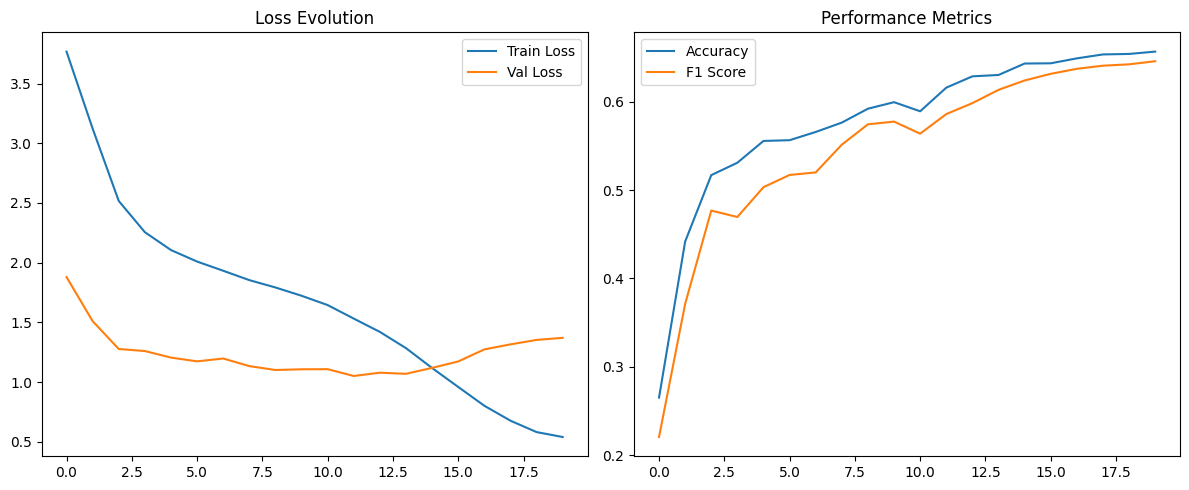

100%|██████████| 113/113 [00:03<00:00, 34.35it/s]


Final Test Accuracy: 0.6569
Final Test F1 Score: 0.6460


In [ ]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
import copy
import torchmetrics

# Configuración de entrenamiento
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {DEVICE} device')
EPOCHS = 20
LR = 1e-3
CHECKPOINT_PATH = 'best_model.pth'

steps_per_epoch = len(train_loader)
total_steps = EPOCHS * steps_per_epoch


# Métricas
train_losses = []
val_losses = []
accuracies = []
f1_scores = []

# Inicialización del modelo
model = CBAM4CNN(num_classes=7).to(DEVICE)

# Quitar la capa Softmax final (corrección importante)
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5, verbose=True)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4,
    verbose=True
)

# Métricas de TorchMetrics
train_acc_metric = torchmetrics.Accuracy(task='multiclass', num_classes=7).to(DEVICE)
val_acc_metric = torchmetrics.Accuracy(task='multiclass', num_classes=7).to(DEVICE)
f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=7, average='macro').to(DEVICE)

# Checkpoint inicial
best_acc = 0.0
best_weights = copy.deepcopy(model.state_dict())

# def train_epoch(model, loader, optimizer):
#     model.train()
#     running_loss = 0.0
#     progress_bar = tqdm(loader, desc='Training', leave=False)

#     for inputs, labels in progress_bar:
#         inputs = inputs.to(DEVICE)
#         labels = labels.to(DEVICE)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         train_acc_metric.update(outputs.softmax(dim=1), labels)

#         progress_bar.set_postfix({'Loss': loss.item()})

#     epoch_loss = running_loss / len(loader.dataset)
#     epoch_acc = train_acc_metric.compute()
#     train_acc_metric.reset()

#     return epoch_loss, epoch_acc
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc='Training', leave=False)

    for inputs, labels in progress_bar:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()  # 👈 Paso importante para OneCycleLR

        running_loss += loss.item() * inputs.size(0)
        train_acc_metric.update(outputs.softmax(dim=1), labels)

        progress_bar.set_postfix({'Loss': loss.item()})

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = train_acc_metric.compute()
    train_acc_metric.reset()

    return epoch_loss, epoch_acc

def validate(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Validation', leave=False):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, 1)

            all_preds.append(preds.to(DEVICE))
            all_labels.append(labels.to(DEVICE))

    epoch_loss = running_loss / len(loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    epoch_acc = val_acc_metric(all_preds, all_labels)
    epoch_f1 = f1_metric(all_preds, all_labels)
    val_acc_metric.reset()
    f1_metric.reset()

    return epoch_loss, epoch_acc, epoch_f1

# Bucle principal de entrenamiento
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')

    # Entrenamiento
    # train_loss, train_acc = train_epoch(model, train_loader, optimizer)
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)


    # Validación
    val_loss, val_acc, val_f1 = validate(model, test_loader)

    # # Actualización del scheduler
    # scheduler.step(val_acc)

    # Guardar métricas
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_acc.item())
    f1_scores.append(val_f1.item())

    # Checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
            'metrics': {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'accuracies': accuracies,
                'f1_scores': f1_scores
            }
        }, CHECKPOINT_PATH)

    # Mostrar progreso
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Val Accuracy: {val_acc:.4f} | Val F1: {val_f1:.4f}')

# Cargar mejor modelo
model.load_state_dict(best_weights)
print(f'\nBest Validation Accuracy: {best_acc:.4f}')

# Visualización de métricas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.plot(f1_scores, label='F1 Score')
plt.title('Performance Metrics')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluación final
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

            all_preds.append(preds.to(DEVICE))
            all_labels.append(labels.to(DEVICE))

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = val_acc_metric(all_preds, all_labels)
    f1 = f1_metric(all_preds, all_labels)

    print(f'\nFinal Test Accuracy: {acc:.4f}')
    print(f'Final Test F1 Score: {f1:.4f}')
    return all_preds.cpu().numpy(), all_labels.cpu().numpy()

# Evaluar en el conjunto de test completo
preds, labels = evaluate_model(model, test_loader)